In [1]:
# Import required packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import xarray as xr
import rasterio as rio
import rioxarray
import geopandas as gpd
import time
from glob import glob
import scipy.signal
from mintpy.utils import readfile, writefile, utils as ut
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
from pathlib import Path

In [2]:
mintpy_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_offsets'
data_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/offsets'

In [3]:
# generate metadata file
lines = [f'{os.path.split(path)[-1]} {os.path.split(path)[-1][5:13]} {os.path.split(path)[-1][14:22]}\n' for path in glob(f'{data_path}/dx_m*.tif')]
lines.sort()
with open(f'{mintpy_path}/metadata.txt', 'w') as f:
    f.writelines(lines)

In [4]:
# Function to write to MintPy config file
def write_config_file(out_file, CONFIG_TXT, mode='a'): 
    """Write configuration files for MintPy to process products"""
    if not os.path.isfile(out_file) or mode == 'w':
        with open(out_file, "w") as fid:
            fid.write(CONFIG_TXT)
        print('write configuration to file: {}'.format(out_file))
    else:
        with open(out_file, "a") as fid:
            fid.write("\n" + CONFIG_TXT)
        print('add the following to file: \n{}'.format(CONFIG_TXT))

In [5]:
CONFIG_TXT = f'''# vim: set filetype=cfg:
##------------------------ smallbaselineApp.cfg ------------------------##
########## computing resource configuration
## parallel processing with dask
## currently apply to steps: invert_network, correct_topography
## cluster   = none to turn off the parallel computing
## numWorker = all  to use all locally available cores (for cluster = local only)
## config    = none to rollback to the default name (same as the cluster type; for cluster != local)
mintpy.compute.cluster   = auto #[local / slurm / pbs / lsf / none], auto for none, cluster type
mintpy.compute.numWorker = auto #[int > 1 / all], auto for 4 (local) or 40 (non-local), num of workers
mintpy.compute.config    = auto #[none / slurm / pbs / lsf ], auto for none (same as cluster), config name

########## 1. load_data
mintpy.load.processor      = cosicorr  #[isce, aria, hyp3, gmtsar, snap, gamma, roipac], auto for isce
mintpy.load.autoPath       = auto  #[yes / no], auto for no, use pre-defined auto path
mintpy.load.updateMode     = no  #[yes / no], auto for yes, skip re-loading if HDF5 files are complete
mintpy.load.compression    = auto  #[gzip / lzf / no], auto for no.
##---------for ISCE only:
mintpy.load.metaFile       = {mintpy_path}/metadata.txt  #[path of common metadata file for the stack], i.e.: ./reference/IW1.xml, ./referenceShelve/data.dat
mintpy.load.baselineDir    = auto  #[path of the baseline dir], i.e.: ./baselines
##---------interferogram datasets:
mintpy.load.unwFile        = auto  #[path pattern of unwrapped interferogram files]
mintpy.load.corFile        = auto  #[path pattern of spatial coherence       files]
mintpy.load.connCompFile   = auto  #[path pattern of connected components    files], optional but recommended
mintpy.load.intFile        = auto  #[path pattern of wrapped interferogram   files], optional
mintpy.load.ionoFile       = auto  #[path pattern of ionospheric delay       files], optional
mintpy.load.magFile        = auto  #[path pattern of interferogram magnitude files], optional
##---------offset datasets (optional):
mintpy.load.azOffFile      = auto  #[path pattern of azimuth offset file], optional
mintpy.load.rgOffFile      = {data_path}/dx_m*.tif  #[path pattern of range   offset file], optional
mintpy.load.offSnrFile     = auto  #[path pattern of offset signal-to-noise ratio file], optional
##---------geometry datasets:
mintpy.load.demFile        = auto  #[path of DEM file]
mintpy.load.lookupYFile    = auto  #[path of latitude /row   /y coordinate file], not required for geocoded data
mintpy.load.lookupXFile    = auto  #[path of longitude/column/x coordinate file], not required for geocoded data
mintpy.load.incAngleFile   = auto  #[path of incidence angle file], optional but recommended
mintpy.load.azAngleFile    = auto  #[path of azimuth   angle file], optional
mintpy.load.shadowMaskFile = auto  #[path of shadow mask file], optional but recommended
mintpy.load.waterMaskFile  = auto  #[path of water  mask file], optional but recommended
mintpy.load.bperpFile      = auto  #[path pattern of 2D perpendicular baseline file], optional
##---------subset (optional):
## if both yx and lalo are specified, use lalo option unless a) no lookup file AND b) dataset is in radar coord
mintpy.subset.yx           = auto    #[y0:y1,x0:x1 / no], auto for no
mintpy.subset.lalo         = auto    #[S:N,W:E / no], auto for no
mintpy.reference.yx        = 1350, 480 

########## 2. modify network
mintpy.network.excludeDate     = auto
'''

In [6]:
os.chdir(mintpy_path)
config_file = f'{mintpy_path}/smallbaselineApp.cfg'
write_config_file(config_file, CONFIG_TXT, mode='w')

write configuration to file: /mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_offsets/smallbaselineApp.cfg


In [7]:
print('#################### starting mintpy ####################')
!load_data.py -t {config_file}  

#################### starting mintpy ####################
processor : cosicorr
SAR platform/sensor : unknown from project name "None"
--------------------------------------------------
prepare metadata files for cosicorr products
prep_cosicorr.py "/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/offsets/dx_m*.tif" --metadata /mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_offsets/metadata.txt
--------------------------------------------------
updateMode : False
compression: None
multilook x/ystep: 1/1
multilook method : nearest
--------------------------------------------------
searching geometry files info
input data files:
--------------------------------------------------
searching interferogram pairs info
input data files:
--------------------------------------------------
searching ionosphere pairs info
input data files:
--------------------------------------------------
searching offset pairs info
input data files:
rangeOffset     : /mnt/Backups/gbrench/re

view.py inputs/offsetStack.h5 rangeOffset --vlim -10 10 -c RdBu_r --noverbose


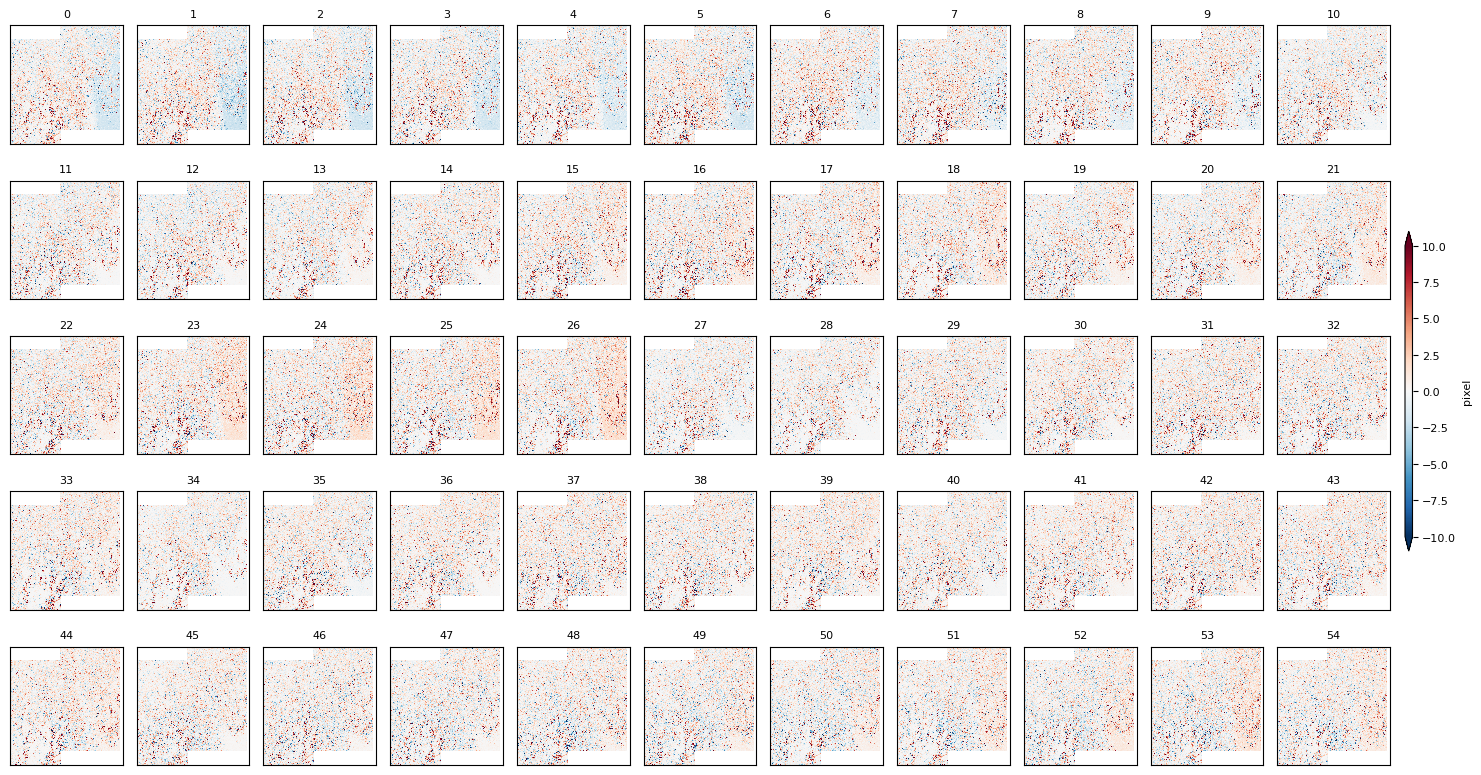

In [8]:
view.main('inputs/offsetStack.h5 rangeOffset --vlim -10 10 -c RdBu_r --noverbose'.split())

In [9]:
!modify_network.py inputs/offsetStack.h5 -t {config_file}

read options from template file: smallbaselineApp.cfg
No lookup table (longitude or rangeCoord) found in files.
No input option found to remove interferogram
Keep all interferograms by enable --reset option
--------------------------------------------------
reset dataset 'dropIfgram' to True for all interferograms for file: inputs/offsetStack.h5
All dropIfgram are already True, no need to reset.


In [10]:
!reference_point.py inputs/offsetStack.h5 -t {config_file}

--------------------------------------------------
reading reference info from template: /mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_offsets/smallbaselineApp.cfg
input reference point in y/x: (1350, 480)
--------------------------------------------------
calculate the temporal average of rangeOffset in file inputs/offsetStack.h5 ...
[======================= 50%                       ] lines 1540/1544    0s /     0s/mnt/Backups/gbrench/sw/insar_tools/MintPy/src/mintpy/objects/stack.py:1059: RuntimeWarning: Mean of empty slice
  dmean[r0:r1, :] = np.nanmean(data, axis=0)
[==================================================] lines 1544/1544 
Add/update ref_x/y attribute to file: inputs/offsetStack.h5
{'REF_Y': '1350', 'REF_X': '480', 'REF_LAT': '-1350.5', 'REF_LON': '480.5'}


read options from template file: smallbaselineApp.cfg
read temporal/spatial baseline info from file: inputs/offsetStack.h5
open ifgramStack file: offsetStack.h5
coherence NOT found in file: inputs/offsetStack.h5! Disable the color coding and continue
number of acquisitions: 17
number of interferograms: 55
shift all perp baseline by 0.0 to zero mean for plotting
--------------------------------------------------
number of interferograms marked as drop: 0
number of interferograms marked as keep: 55
number of acquisitions marked as drop: 0
max perpendicular baseline: 0.00 m
max temporal      baseline: 192.0 days
showing ...


/mnt/Backups/gbrench/sw/insar_tools/MintPy/src/mintpy/utils/plot.py:507: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([ymin, ymax])


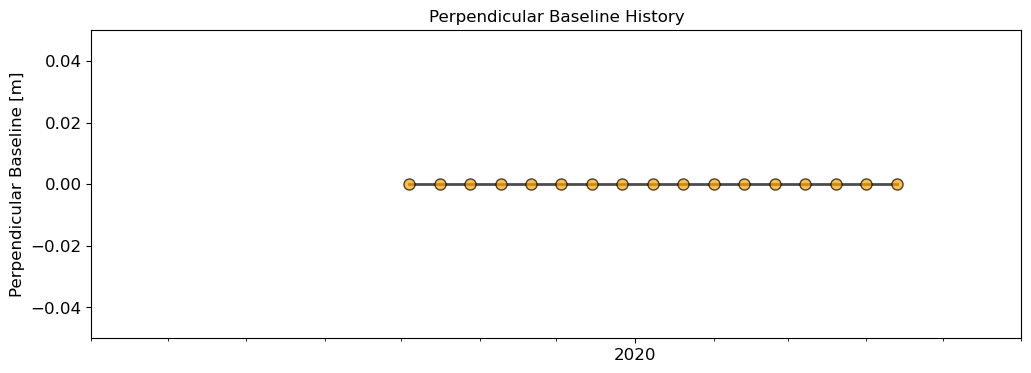

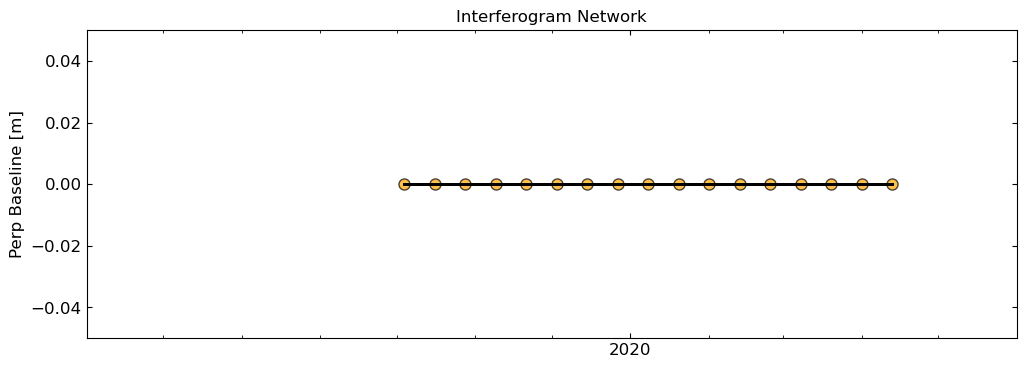

In [11]:
plot_network.main('inputs/offsetStack.h5 -t smallbaselineApp.cfg --figsize 12 4'.split())

In [12]:
!ifgram_inversion.py inputs/offsetStack.h5 -t {config_file} -i rangeOffset -w no -o timeseriesRg.h5 residualInvRg.h5 numInvOffsetRg.h5

read input option from template file: /mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_offsets/smallbaselineApp.cfg
save the original settings of ['OMP_NUM_THREADS', 'OPENBLAS_NUM_THREADS', 'MKL_NUM_THREADS', 'NUMEXPR_NUM_THREADS', 'VECLIB_MAXIMUM_THREADS']
set OMP_NUM_THREADS = 1
set OPENBLAS_NUM_THREADS = 1
set MKL_NUM_THREADS = 1
set NUMEXPR_NUM_THREADS = 1
set VECLIB_MAXIMUM_THREADS = 1
reference pixel in y/x: (1350, 480) from dataset: rangeOffset
-------------------------------------------------------------------------------
least-squares solution with L2 min-norm on: deformation velocity
minimum redundancy: 1.0
weight function: no
calculate covariance: False 
mask: no
-------------------------------------------------------------------------------
number of interferograms: 55
number of acquisitions  : 17
number of lines   : 1544
number of columns : 1472
--------------------------------------------------
create HDF5 file: timeseriesRg.h5 with w mode
create dataset  :

view.py residualInvRg.h5 --noverbose --vlim -50 50 -c RdBu_r


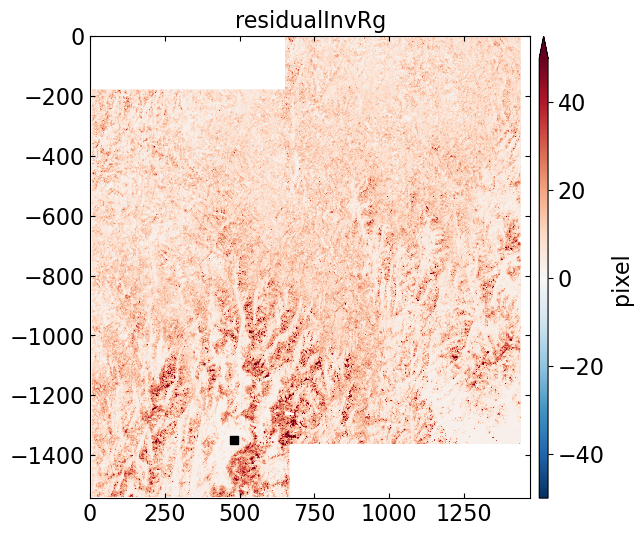

In [13]:
view.main('residualInvRg.h5 --noverbose --vlim -50 50 -c RdBu_r'.split())

view.py timeseriesRg.h5 --noverbose --vlim -500 500 -c RdBu_r


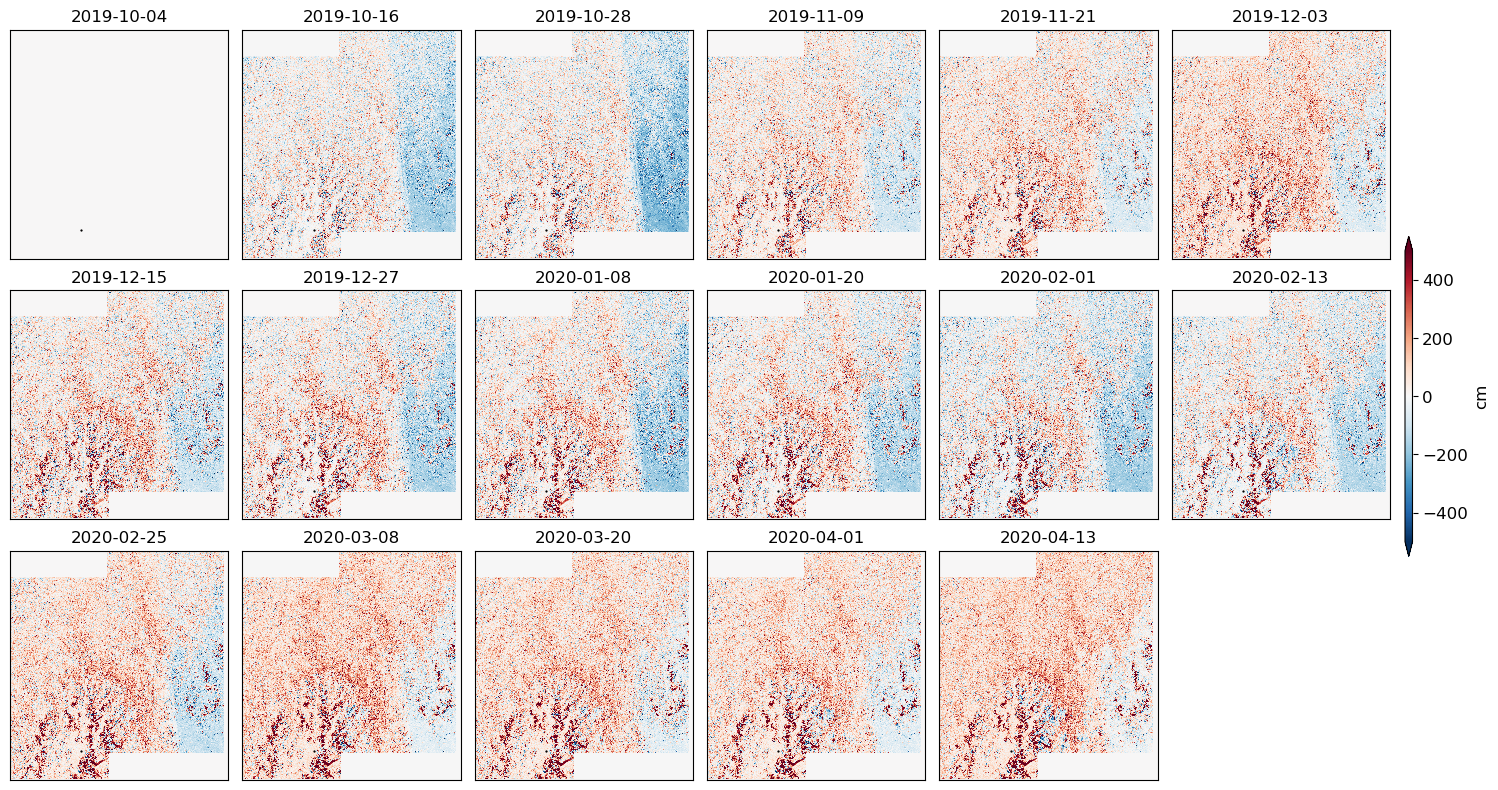

In [14]:
view.main('timeseriesRg.h5 --noverbose --vlim -500 500 -c RdBu_r'.split())

In [15]:
!timeseries2velocity.py timeseriesRg.h5 -t {config_file} -o velocityRg.h5 

read options from template file: smallbaselineApp.cfg
open timeseries file: timeseriesRg.h5
--------------------------------------------------
dates from input file: 17
['20191004', '20191016', '20191028', '20191109', '20191121', '20191203', '20191215', '20191227', '20200108', '20200120', '20200201', '20200213', '20200225', '20200308', '20200320', '20200401', '20200413']
--------------------------------------------------
using all dates to calculate the time function
--------------------------------------------------
estimate deformation model with the following assumed time functions:
    polynomial : 1
    periodic   : []
    stepDate   : []
    polyline   : []
    exp        : {}
    log        : {}
add/update the following configuration metadata:
['startDate', 'endDate', 'excludeDate', 'polynomial', 'periodic', 'stepDate', 'exp', 'log', 'uncertaintyQuantification', 'timeSeriesCovFile', 'bootstrapCount']
--------------------------------------------------
create HDF5 file: velocityRg

view.py velocityRg.h5 --noverbose --vlim -20 20 -c RdBu_r


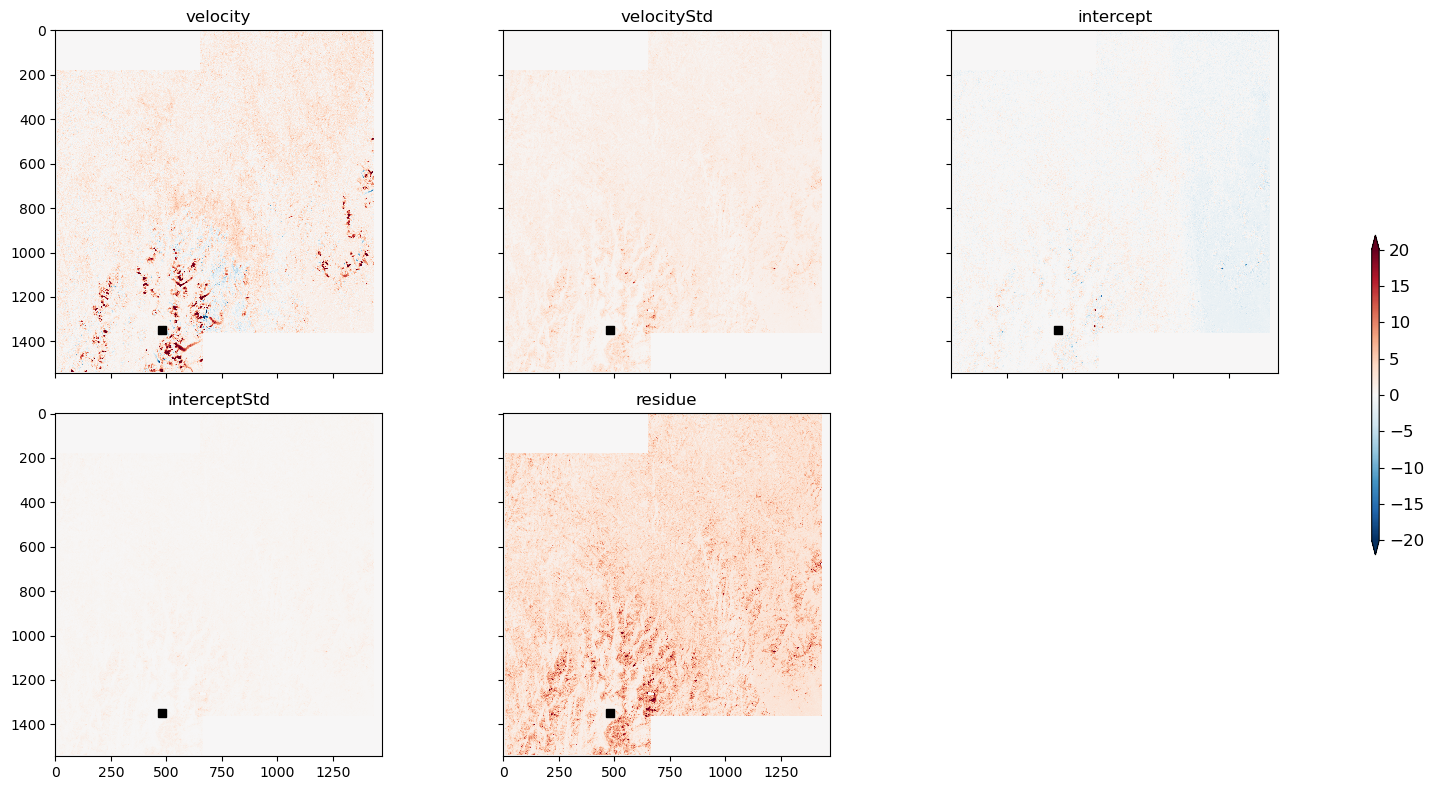

In [21]:
view.main('velocityRg.h5 --noverbose --vlim -25 2 -c RdBu_r'.split())